# Lab2 - Transfer Learning
### Artem Fisunenko, MI-4

#### Installations


In [1]:
#%pip install tensorflow==2.1.0
#%pip install segmentation-models
#%pip install h5py==2.10.0
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install keras==2.3.1
#%pip install pandas
#%pip install tensorflow_datasets
#%pip install seaborn
#%pip install sklearn

#### Imports

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

#### Loading data

In [3]:
(x_train, y_train), (x_test, y_test) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True,  # Include labels
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


#### Preprocessing data

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_test)
test_labels_encoded = le.transform(y_test)
le.fit(y_train)
train_labels_encoded = le.transform(y_train)

size = (224, 224)

x_train = tf.image.resize(x_train, size)
x_test = tf.image.resize(x_test, size)
x_train /= 255.0
x_test /= 255.0

y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

#### Constructing base model

In [5]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


#### Feature extraction

In [6]:
feature_extractor = base_model.predict(x_train)
x_w_features = feature_extractor.reshape(feature_extractor.shape[0], -1)

x_test_feature = base_model.predict(x_test)
x_test_features = x_test_feature.reshape(x_test_feature.shape[0], -1)

#### K-Nearest Neighbors

In [7]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(x_w_features, y_train)

KNeighborsClassifier()

#### Model's prediction

In [8]:
prediction = model.predict(x_test_features)
prediction = le.inverse_transform(prediction)

#### Accuracy

In [9]:
print(f"Accuracy: {round(accuracy_score(y_test, prediction)*100, 2)}%")

Accuracy: 58.04%


#### Confusion matrix

[Text(0, 0.5, 'dandelion'),
 Text(0, 1.5, 'daisy'),
 Text(0, 2.5, 'tulips'),
 Text(0, 3.5, 'sunflowers'),
 Text(0, 4.5, 'roses')]

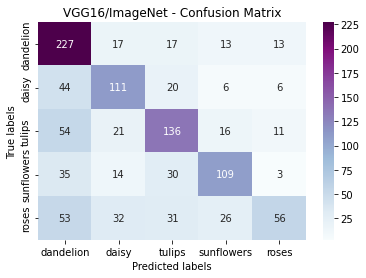

In [10]:
cm = confusion_matrix(y_test, prediction)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='BuPu')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('VGG16/ImageNet - Confusion Matrix')

classes = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

#### Scatterplot

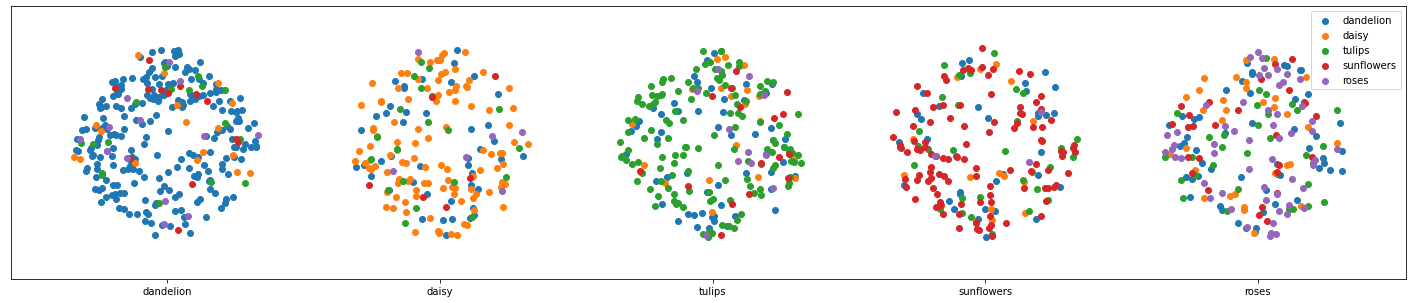

In [11]:
import random
cm = np.transpose(cm)
X = []
Y = []

for col in cm:
    data_x, data_y = [], []

    for j, count in enumerate(col):
        radius = 0.35
        rnd = [random.random() * 2 * np.pi for _ in range(count)]
        data_x.extend([radius * (random.random() ** 0.5) * np.cos(rnd[_]) + j for _ in range(count)])
        data_y.extend([radius * (random.random() ** 0.5) * np.sin(rnd[_]) + 0.5 for _ in range(count)])
    
    X.append(data_x)
    Y.append(data_y)

for i in range(len(X)):
    plt.scatter(X[i], Y[i], label=classes[i])

plt.style.use('default')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
fig = plt.gcf()
fig.set_size_inches(25, 20, forward=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(0, 1)
plt.legend()
plt.xticks(np.arange(5), classes)
plt.show()